In [11]:
import numpy as np
import tensorflow as tf
import pandas as pd
import sys
sys.path.append('C:/Users/dylan/Documents/')
from nbc.nbc import NBC
import argparse
import random
import scipy
import matplotlib.pyplot as plt
import sklearn

In [12]:
def evaluate_model(model, train_dset, dev_dset, verbose=0, n_trials=10):
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    model.evaluate(x=train_dset, verbose=0)
    model.save_weights('models/initial.h5')
    trials = []
    for i in range(n_trials):
        model.load_weights('models/initial.h5')
        model.fit(x=train_dset, epochs=1000, shuffle=True, validation_data=dev_dset, verbose=verbose, \
                  callbacks=[tf.keras.callbacks.EarlyStopping(patience=5, verbose=verbose),
                            tf.keras.callbacks.ModelCheckpoint('models/tmp.h5', save_best_only=True)])
        model.load_weights('models/tmp.h5')
        _, acc = model.evaluate(x=dev_dset, verbose=0)
        trials.append(acc)
    return np.array(trials)

In [13]:
def report_acc(trials):
    print('Dev accuracy across training trials:')
    for trial in trials:
        print('{:.2f}'.format(100*trial))
    print('avg: {:.2f}\nbest: {:.2f}'.format(100*np.mean(trials), 100*np.max(trials)))

# 1. Apple motion

In [14]:
#get dataset
class Args:
    def __init__(self):
        self.subsample = 5
        self.dynamic_only = True
        self.train_sequencing = 'actions'
        self.dev_sequencing = 'actions'
        self.test_sequencing = 'actions'
        self.chunk_size = 10
        self.label_method = 'actions_rhand_apple'
        self.features = ['speed:Apple']
        self.trim = -1
        self.preprocess = False
        self.recache = False
nbc = NBC(Args())

loaded cached data from args


(73, 58, 1)


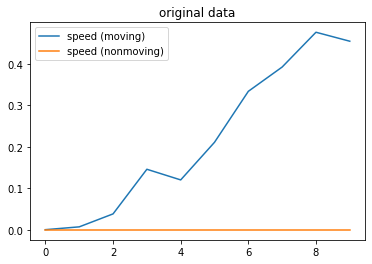

In [15]:
#convert data
seq_len = 0
for type in ['train', 'dev', 'test']:
    for seq in nbc.labels[type].values():
        if seq.shape[0] > seq_len:
            seq_len = seq.shape[0]
n_dim = next(iter(nbc.features['train'].values())).shape[-1]
x = {}; y = {}            
for type in ['train', 'dev', 'test']:
    n = len(nbc.labels[type])
    x[type] = np.ones((n, seq_len, n_dim)).astype(np.float32) * -1e9
    y[type] = np.zeros((n,)).astype(int)
    for i, (key, labels) in enumerate(nbc.labels[type].items()):
        steps = nbc.steps[type][key]
        start_step, end_step = steps[0], steps[-1]
        end_step = start_step + labels.shape[0]
        assert np.all(labels == labels[0])
        mapping = {0: 0, 1: 0, 2: 1, 3: 1, 4: 0}
        label = mapping[labels[0]]
        feat = nbc.features[type][key]
        x[type][i,:feat.shape[0],:] = feat
        y[type][i] = label
print(x['train'].shape)
moving_idx = (y['train'] == 1).argmax()
nonmoving_idx = (y['train'] == 0).argmax()
plt.plot(x['train'][moving_idx,:10,0], label='speed (moving)')
plt.plot(x['train'][nonmoving_idx,:10,0], label='speed (nonmoving)')
plt.title('original data')
plt.legend()
plt.show()

## Preprocessing tests

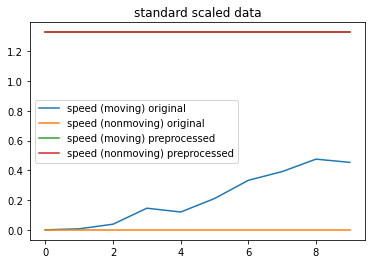

In [19]:
x_scaled = {}
scaler = sklearn.preprocessing.StandardScaler()
scaler.fit(x['train'].reshape((-1, n_dim)))
for type in ['train', 'dev', 'test']:
    x_scaled[type] = scaler.transform(x[type].reshape((-1, n_dim))).reshape((-1, seq_len, n_dim))
moving_idx = (y['train'] == 1).argmax()
nonmoving_idx = (y['train'] == 0).argmax()
plt.plot(x['train'][moving_idx,:10,0], label='speed (moving) original')
plt.plot(x['train'][nonmoving_idx,:10,0], label='speed (nonmoving) original')
plt.plot(x_scaled['train'][moving_idx,:10,0], label='speed (moving) preprocessed')
plt.plot(x_scaled['train'][nonmoving_idx,:10,0], label='speed (nonmoving) preprocessed')
plt.title('standard scaled data')
plt.legend()
plt.show()

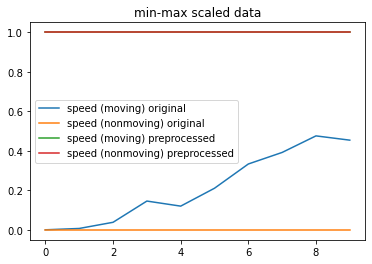

In [20]:
x_scaled = {}
scaler = sklearn.preprocessing.MinMaxScaler()
scaler.fit(x['train'].reshape((-1, n_dim)))
for type in ['train', 'dev', 'test']:
    x_scaled[type] = scaler.transform(x[type].reshape((-1, n_dim))).reshape((-1, seq_len, n_dim))
moving_idx = (y['train'] == 1).argmax()
nonmoving_idx = (y['train'] == 0).argmax()
plt.plot(x['train'][moving_idx,:10,0], label='speed (moving) original')
plt.plot(x['train'][nonmoving_idx,:10,0], label='speed (nonmoving) original')
plt.plot(x_scaled['train'][moving_idx,:10,0], label='speed (moving) preprocessed')
plt.plot(x_scaled['train'][nonmoving_idx,:10,0], label='speed (nonmoving) preprocessed')
plt.title('min-max scaled data')
plt.legend()
plt.show()

## IF-statment classifier test

In [21]:
acc = {}
for type in ['train', 'dev']:
    x_ = x[type][:,5,0]
    y_pred = (x_ > 1e-3).astype(int)
    correct = (y_pred == y[type]).sum()
    total = y[type].shape[0]
    acc[type] = correct / total
print('Train acc: {:.2f}\nDev acc: {:.2f}'.format(100*acc['train'], 100*acc['dev']))

Train acc: 95.89
Dev acc: 100.00


## Linear Regression

In [22]:
from sklearn.linear_model import LogisticRegression
for scaling in [1, 1e3]:
    print('Scaling: {}'.format(scaling))
    clf = LogisticRegression().fit(x['train'][:,5,:] * scaling, y['train'])
    train_acc = clf.score(x['train'][:,5,:] * scaling, y['train'])
    dev_acc = clf.score(x['dev'][:,5,:] * scaling, y['dev'])
    print('Train acc: {:.2f}\nDev acc: {:.2f}'.format(100*train_acc, 100*dev_acc))
    print('')

Scaling: 1
Train acc: 90.41
Dev acc: 85.71

Scaling: 1000.0
Train acc: 98.63
Dev acc: 100.00



## Naive svm classifier test

In [23]:
from sklearn.svm import SVC
scaling = 1
classifier = SVC()
classifier.fit(x['train'][:,5,:] * scaling, y['train'])
train_acc = classifier.score(x['train'][:,5,:] * scaling, y['train'])
dev_acc = classifier.score(x['dev'][:,5,:] * scaling, y['dev'])
print('Train acc: {:.2f}\nDev acc: {:.2f}'.format(100*train_acc, 100*dev_acc))

Train acc: 89.04
Dev acc: 78.57


## Neural models

### Feed-foward classifier

In [25]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Masking(mask_value=-1e9),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(.5),
    tf.keras.layers.Dense(2, activation='softmax')
])
train_dset = tf.data.Dataset.from_tensor_slices((x['train'], y['train'])).batch(10)
dev_dset = tf.data.Dataset.from_tensor_slices((x['dev'], y['dev'])).batch(10)
trials = evaluate_model(model, train_dset, dev_dset)
model.summary()
report_acc(trials)

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
masking_5 (Masking)          (None, 58, 1)             0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 58)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 128)               7552      
_________________________________________________________________
dropout_5 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 2)                 258       
Total params: 7,810
Trainable params: 7,810
Non-trainable params: 0
_________________________________________________________________
Dev accuracy across training trials:
100.00
100.00
100.00
100.00
100.00
100.00
100.00
100.00
100.00
100.00
avg: 100.00

### LSTM

In [26]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Masking(mask_value=-1e9),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dropout(.5),
    tf.keras.layers.Dense(2, activation='softmax')
])
train_dset = tf.data.Dataset.from_tensor_slices((x['train'], y['train'])).batch(10)
dev_dset = tf.data.Dataset.from_tensor_slices((x['dev'], y['dev'])).batch(10)
trials = evaluate_model(model, train_dset, dev_dset)
model.summary()
report_acc(trials)

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
masking_6 (Masking)          (None, 58, 1)             0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 64)                8704      
_________________________________________________________________
dropout_6 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_11 (Dense)             (None, 2)                 130       
Total params: 8,834
Trainable params: 8,834
Non-trainable params: 0
_________________________________________________________________
Dev accuracy across training trials:
100.00
100.00
100.00
100.00
100.00
100.00
100.00
100.00
100.00
100.00
avg: 100.00
best: 100.00


# 2. Hand motion classifier
- All actions
- Combine reach/put and pick/retract

In [27]:
class Args:
    def __init__(self):
        self.subsample = 5
        self.dynamic_only = True
        self.train_sequencing = 'actions'
        self.dev_sequencing = 'actions'
        self.test_sequencing = 'actions'
        self.chunk_size = 10
        self.label_method = 'actions_rhand_apple'
        self.features = ['velY:RightHand', 'relVelZ:RightHand']
        self.trim = -1
        self.preprocess = False
        self.recache = False
nbc = NBC(Args())

loaded cached data from args


In [28]:
seq_len = 0
for type in ['train', 'dev', 'test']:
    for seq in nbc.labels[type].values():
        if seq.shape[0] > seq_len:
            seq_len = seq.shape[0]
n_dim = next(iter(nbc.features['train'].values())).shape[-1]
x = {}; y = {}            
for type in ['train', 'dev', 'test']:
    n = len(nbc.labels[type])
    x[type] = np.ones((n, seq_len, n_dim)).astype(np.float32) * -1e9
    y[type] = np.zeros((n,)).astype(int)
    for i, (key, labels) in enumerate(nbc.labels[type].items()):
        steps = nbc.steps[type][key]
        start_step, end_step = steps[0], steps[-1]
        end_step = start_step + labels.shape[0]
        assert np.all(labels == labels[0])
        mapping = {0: 0, 1: 0, 2: 1, 3: 0, 4: 1}
        label = mapping[labels[0]]
        feat = nbc.features[type][key]
        x[type][i,:feat.shape[0],:] = feat
        y[type][i] = label
print(x['train'].shape)
print(x['train'][:10,5,:], y['train'][:10])

(73, 58, 2)
[[-0.16303833  0.31619036]
 [ 0.27326167 -0.53960186]
 [ 0.30801415 -0.09630696]
 [-0.11376747  0.4178113 ]
 [ 0.02074307  0.07182815]
 [ 0.31561887 -0.36012173]
 [ 0.13641337 -0.02102578]
 [-0.5724461   0.6479125 ]
 [ 0.2641104  -0.14628907]
 [ 0.06321614 -0.06387794]] [0 1 1 0 0 1 1 0 1 1]


## Linear Regression

In [29]:
from sklearn.linear_model import LogisticRegression
for scaling in [1, 1e3]:
    print('Scaling: {}'.format(scaling))
    clf = LogisticRegression().fit(x['train'][:,5,:] * scaling, y['train'])
    train_acc = clf.score(x['train'][:,5,:] * scaling, y['train'])
    dev_acc = clf.score(x['dev'][:,5,:] * scaling, y['dev'])
    print('Train acc: {:.2f}\nDev acc: {:.2f}'.format(100*train_acc, 100*dev_acc))
    print('')

Scaling: 1
Train acc: 100.00
Dev acc: 92.86

Scaling: 1000.0
Train acc: 100.00
Dev acc: 92.86



## SVM

In [30]:
from sklearn.svm import SVC
classifier = SVC()
classifier.fit(x['train'].reshape((x['train'].shape[0], -1)), y['train'])
train_acc = classifier.score(x['train'].reshape((x['train'].shape[0], -1)), y['train'])
dev_acc = classifier.score(x['dev'].reshape((x['dev'].shape[0], -1)), y['dev'])
print('Train acc: {:.2f}\nDev acc: {:.2f}'.format(100*train_acc, 100*dev_acc))

Train acc: 63.01
Dev acc: 50.00


## Neural

In [31]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Masking(mask_value=-1e9),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(.5),
    tf.keras.layers.Dense(2, activation='softmax')
])
train_dset = tf.data.Dataset.from_tensor_slices((x['train'], y['train'])).batch(10)
dev_dset = tf.data.Dataset.from_tensor_slices((x['dev'], y['dev'])).batch(10)
trials = evaluate_model(model, train_dset, dev_dset)
model.summary()
report_acc(trials)

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
masking_7 (Masking)          (None, 58, 2)             0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 116)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 128)               14976     
_________________________________________________________________
dropout_7 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 2)                 258       
Total params: 15,234
Trainable params: 15,234
Non-trainable params: 0
_________________________________________________________________
Dev accuracy across training trials:
92.86
92.86
92.86
92.86
92.86
92.86
92.86
92.86
92.86
92.86
avg: 92.86
best: 92

### LSTM

In [32]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Masking(mask_value=-1e9),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dropout(.5),
    tf.keras.layers.Dense(2, activation='softmax')
])
train_dset = tf.data.Dataset.from_tensor_slices((x['train'], y['train'])).batch(10)
dev_dset = tf.data.Dataset.from_tensor_slices((x['dev'], y['dev'])).batch(10)
trials = evaluate_model(model, train_dset, dev_dset)
model.summary()
report_acc(trials)

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
masking_8 (Masking)          (None, 58, 2)             0         
_________________________________________________________________
bidirectional_2 (Bidirection (None, 64)                8960      
_________________________________________________________________
dropout_8 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_14 (Dense)             (None, 2)                 130       
Total params: 9,090
Trainable params: 9,090
Non-trainable params: 0
_________________________________________________________________
Dev accuracy across training trials:
92.86
100.00
92.86
92.86
100.00
92.86
92.86
92.86
92.86
92.86
avg: 94.29
best: 100.00


# 3. All action classifier

In [41]:
class Args:
    def __init__(self):
        self.subsample = 5
        self.dynamic_only = True
        self.train_sequencing = 'actions'
        self.dev_sequencing = 'actions'
        self.test_sequencing = 'actions'
        self.chunk_size = 10
        self.label_method = 'actions'
        self.features = ['speed:objs', 'velY:hands', 'relVelZ:hands']
        self.trim = -1
        self.preprocess = False
        self.recache = False
nbc = NBC(Args())

loaded cached data from args


In [42]:
seq_len = 0
for type in ['train', 'dev', 'test']:
    for seq in nbc.labels[type].values():
        if seq.shape[0] > seq_len:
            seq_len = seq.shape[0]
n_dim = next(iter(nbc.features['train'].values())).shape[-1]
x = {}; y = {}            
for type in ['train', 'dev', 'test']:
    n = len(nbc.labels[type])
    x[type] = np.ones((n, seq_len, n_dim)).astype(np.float32) * -1e9
    y[type] = np.zeros((n,)).astype(int)
    for i, (key, labels) in enumerate(nbc.labels[type].items()):
        steps = nbc.steps[type][key]
        start_step, end_step = steps[0], steps[-1]
        end_step = start_step + labels.shape[0]
        assert np.all(labels == labels[0])
        label = labels[0] - 1
        feat = nbc.features[type][key]
        x[type][i,:feat.shape[0],:] = feat
        y[type][i] = label
print(x['train'].shape)
print(x['train'][:10,5,:], y['train'][:10])

(845, 74, 15)
[[ 0.0000000e+00  0.0000000e+00  0.0000000e+00  1.0793907e-01
   0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
   0.0000000e+00  0.0000000e+00  0.0000000e+00  3.1298645e-02
   2.5881323e-01  8.1865294e-03 -1.6559821e-01]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
   3.5537571e-01  0.0000000e+00  0.0000000e+00  0.0000000e+00
   0.0000000e+00  0.0000000e+00  0.0000000e+00  3.6727343e-02
   3.2558373e-01 -3.1837724e-02 -3.3995566e-01]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
   0.0000000e+00  0.0000000e+00  0.0000000e+00  6.8220919e-01
   0.0000000e+00  0.0000000e+00  0.0000000e+00 -1.8411506e-02
  -1.3911631e-03  1.8769807e-01 -6.6167623e-01]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
   0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
   1.5517409e-01  0.0000000e+00  0.0000000e+00 -1.0531467e-01
   2.5825053e-01  1.6375180e-01 -3.7107444e-01]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00  7.

## SVM

In [35]:
from sklearn.svm import SVC
classifier = SVC()
classifier.fit(x['train'].reshape((x['train'].shape[0], -1)), y['train'])
train_acc = classifier.score(x['train'].reshape((x['train'].shape[0], -1)), y['train'])
dev_acc = classifier.score(x['dev'].reshape((x['dev'].shape[0], -1)), y['dev'])
print('Train acc: {:.2f}\nDev acc: {:.2f}'.format(100*train_acc, 100*dev_acc))

Train acc: 37.16
Dev acc: 33.09


## Neural

In [36]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Masking(mask_value=-1e9),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(.5),
    tf.keras.layers.Dense(4, activation='softmax')
])
train_dset = tf.data.Dataset.from_tensor_slices((x['train'], y['train'])).batch(10)
dev_dset = tf.data.Dataset.from_tensor_slices((x['dev'], y['dev'])).batch(10)
trials = evaluate_model(model, train_dset, dev_dset)
model.summary()
report_acc(trials)

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
masking_9 (Masking)          (None, 74, 15)            0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 1110)              0         
_________________________________________________________________
dense_15 (Dense)             (None, 128)               142208    
_________________________________________________________________
dropout_9 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_16 (Dense)             (None, 4)                 516       
Total params: 142,724
Trainable params: 142,724
Non-trainable params: 0
_________________________________________________________________
Dev accuracy across training trials:
92.65
92.65
91.91
93.38
92.65
92.65
92.65
91.91
92.65
92.65
avg: 92.57
best: 

In [37]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Masking(mask_value=-1e9),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True, dropout=.5)),
    tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(32, activation='relu')),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(4, activation='softmax')
])
train_dset = tf.data.Dataset.from_tensor_slices((x['train'], y['train'])).batch(10)
dev_dset = tf.data.Dataset.from_tensor_slices((x['dev'], y['dev'])).batch(10)
trials = evaluate_model(model, train_dset, dev_dset)
model.summary()
report_acc(trials)

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
masking_10 (Masking)         (None, 74, 15)            0         
_________________________________________________________________
bidirectional_3 (Bidirection (None, 74, 64)            12288     
_________________________________________________________________
time_distributed (TimeDistri (None, 74, 32)            2080      
_________________________________________________________________
flatten_7 (Flatten)          (None, 2368)              0         
_________________________________________________________________
dense_18 (Dense)             (None, 32)                75808     
_________________________________________________________________
dense_19 (Dense)             (None, 4)                 132       
Total params: 90,308
Trainable params: 90,308
Non-trainable params: 0
_________________________________________________

## Try z-norm

In [53]:
x_scaled = {}
scaler = sklearn.preprocessing.StandardScaler()
mask = ~(x['train'] == -1e9)
scaler.fit(x['train'][mask].reshape((-1, n_dim)))
for type in ['train', 'dev', 'test']:
    mask = ~(x[type] == -1e9)
    x_scaled[type] = np.ones(x[type].shape) * -1e9
    x_scaled[type][mask] = scaler.transform(x[type][mask].reshape((-1, n_dim))).reshape(x[type][mask].shape)
print(x_scaled['train'].shape)
print(x_scaled['train'][:10,5,:], y['train'][:10])

(845, 74, 15)
[[-0.16077961 -0.10479045 -0.09691585  0.24167587 -0.1104331  -0.15118545
  -0.14507519 -0.10592994 -0.10317923 -0.17269525 -0.03505127  0.08862365
   0.81870431 -0.12382942 -0.59185845]
 [-0.16077961 -0.10479045 -0.09691585 -0.14135773  2.86564374 -0.15118545
  -0.14507519 -0.10592994 -0.10317923 -0.17269525 -0.03505127  0.11268587
   1.04411018 -0.27654141 -1.07103109]
 [-0.16077961 -0.10479045 -0.09691585 -0.14135773 -0.1104331  -0.15118545
  -0.14507519  3.46785569 -0.10317923 -0.17269525 -0.03505127 -0.13171209
  -0.05970185  0.56109434 -1.95518994]
 [-0.16077961 -0.10479045 -0.09691585 -0.14135773 -0.1104331  -0.15118545
  -0.14507519 -0.10592994  0.69619477 -0.17269525 -0.03505127 -0.51690251
   0.81680471  0.46972772 -1.15655231]
 [-0.16077961 -0.10479045 -0.09691585 -0.14133087 -0.1104331  -0.15118545
  -0.14507519 -0.10592893 -0.10317923 -0.12908198 -0.03505127  0.05406673
   0.16393991 -0.25261277 -0.26960367]
 [-0.16077961 -0.10479045 -0.09691585  2.29688954 -

## Feed-forward

In [54]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Masking(mask_value=-1e9),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(.5),
    tf.keras.layers.Dense(4, activation='softmax')
])
train_dset = tf.data.Dataset.from_tensor_slices((x_scaled['train'], y['train'])).batch(10)
dev_dset = tf.data.Dataset.from_tensor_slices((x_scaled['dev'], y['dev'])).batch(10)
trials = evaluate_model(model, train_dset, dev_dset)
model.summary()
report_acc(trials)

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
masking_12 (Masking)         (None, 74, 15)            0         
_________________________________________________________________
flatten_9 (Flatten)          (None, 1110)              0         
_________________________________________________________________
dense_22 (Dense)             (None, 128)               142208    
_________________________________________________________________
dropout_11 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_23 (Dense)             (None, 4)                 516       
Total params: 142,724
Trainable params: 142,724
Non-trainable params: 0
_________________________________________________________________
Dev accuracy across training trials:
83.09
83.82
80.15
83.09
83.82
77.21
72.79
83.82
80.88
84.56
avg: 81.32
best:

## LSTM

In [55]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Masking(mask_value=-1e9),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True, dropout=.5)),
    tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(32, activation='relu')),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(4, activation='softmax')
])
train_dset = tf.data.Dataset.from_tensor_slices((x_scaled['train'], y['train'])).batch(10)
dev_dset = tf.data.Dataset.from_tensor_slices((x_scaled['dev'], y['dev'])).batch(10)
trials = evaluate_model(model, train_dset, dev_dset)
model.summary()
report_acc(trials)

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
masking_13 (Masking)         (None, 74, 15)            0         
_________________________________________________________________
bidirectional_4 (Bidirection (None, 74, 64)            12288     
_________________________________________________________________
time_distributed_1 (TimeDist (None, 74, 32)            2080      
_________________________________________________________________
flatten_10 (Flatten)         (None, 2368)              0         
_________________________________________________________________
dense_25 (Dense)             (None, 32)                75808     
_________________________________________________________________
dense_26 (Dense)             (None, 4)                 132       
Total params: 90,308
Trainable params: 90,308
Non-trainable params: 0
_________________________________________________